<a href="https://colab.research.google.com/github/MengOonLee/AccountReceivable/blob/main/Workflow/InvoicePayment/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Invoice Payment Forecasting

Accounts Receivables (AR) is an important aspect of businesses, it is a credit extended by the company to the client that require payments due within a time period. With B2B transactions increasing in volume and complexity, poor management of AR can lead to to unnecessary cash flow problems.

Invoice payment forecasting can be used to optimize collection strategies that allows businesses to predict and plan for future customer payments. By analyzing customer payment history, businesses can forecast their future accounts receivable balance and plan accordingly. By identifying invoices that are likely to be paid late, customers who are likely to have large amounts of overdue receivables, which in turn can lead to better visibility into future cash flow.

The invoices dataset contains the past payment information and behaviour of various buyers [here](https://www.kaggle.com/datasets/hhenry/finance-factoring-ibm-late-payment-histories).

The goal is to leverage LLM to forecast time series in a sentence-to-sentence fashion. In order to achieve this goal, the numerical time series values need to be transferred and described as natural language sentences. Specifically, the input numerical sequence $x^m_{t_1:t_{obs}}$ is turned into input prompts, and the forecasting target values are transformed as the output prompt. Consequently, time series forecasting can be addressed through a natural language generation paradigm, and LLM can be adopted as the core forecasting models.

Instruction fine-tuning is a common technique used to fine-tune a base LLM for a specific use-case using own datasets.

In [1]:
import warnings
warnings.filterwarnings('ignore')
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Pre-processing dataset

In [2]:
import os
import pandas as pd

input_dir = '../../Data/Input'
input_invoice = 'WA_Fn-UseC_-Accounts-Receivable.csv'
df = pd.read_csv(os.path.join(input_dir, input_invoice))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   countryCode    2466 non-null   int64  
 1   customerID     2466 non-null   object 
 2   PaperlessDate  2466 non-null   object 
 3   invoiceNumber  2466 non-null   int64  
 4   InvoiceDate    2466 non-null   object 
 5   DueDate        2466 non-null   object 
 6   InvoiceAmount  2466 non-null   float64
 7   Disputed       2466 non-null   object 
 8   SettledDate    2466 non-null   object 
 9   PaperlessBill  2466 non-null   object 
 10  DaysToSettle   2466 non-null   int64  
 11  DaysLate       2466 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 231.3+ KB


,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4


In [3]:
import pandas as pd

df_invoice = df.copy()

for c in ['InvoiceDate']:
    df_invoice[c] = pd.to_datetime(df_invoice[c],
        format='%m/%d/%Y').dt.date

df_invoice.sort_values(by=['customerID', 'InvoiceDate'], inplace=True)
df_invoice.drop(columns=['countryCode', 'PaperlessDate', 'invoiceNumber',
    'DueDate', 'Disputed', 'SettledDate', 'PaperlessBill', 'DaysLate'],
    inplace=True)

df_invoice[df_invoice['customerID']=='2621-XCLEH']

,customerID,InvoiceDate,InvoiceAmount,DaysToSettle
1607,2621-XCLEH,2012-01-13,80.99,61
139,2621-XCLEH,2012-02-21,79.51,46
946,2621-XCLEH,2012-02-22,69.80,43
1431,2621-XCLEH,2012-03-02,67.51,57
1404,2621-XCLEH,2012-03-23,89.05,52
2152,2621-XCLEH,2012-04-16,74.06,44
1100,2621-XCLEH,2012-06-27,69.42,60
1882,2621-XCLEH,2012-11-18,86.39,75
1695,2621-XCLEH,2013-03-01,58.96,55
28,2621-XCLEH,2013-03-31,70.93,55


In [18]:
mask = df_invoice['customerID']=='2621-XCLEH'
sample = df_invoice[mask].drop(columns=['customerID'])\
    .set_index('InvoiceDate')
sample_train = sample[:-1]
sample_test = sample[-1:]

prompt = f"""\
Given the dataset delimited by the triple backticks, \
forecast number of days it will take for the payment of an invoice \
dated {sample_test.index.values[0]} with an amount \
{sample_test['InvoiceAmount'].values[0]} to be settled.

Return the answer in JSON format, containing three keys: \
'InvoiceDate', 'InvoiceAmount' and 'DaysToSettle'. \
Return only the forecast, not the Python code.

```
{sample_train.to_string()}
```\
"""

prompt

"Given the dataset delimited by the triple backticks, forecast number of days it will take for the payment of an invoice dated 2013-07-28 with an amount 92.17 to be settled.\n\nReturn the answer in JSON format, containing three keys: 'InvoiceDate', 'InvoiceAmount' and 'DaysToSettle'. Return only the forecast, not the Python code.\n\n```\n             InvoiceAmount  DaysToSettle\nInvoiceDate                             \n2012-01-13           80.99            61\n2012-02-21           79.51            46\n2012-02-22           69.80            43\n2012-03-02           67.51            57\n2012-03-23           89.05            52\n2012-04-16           74.06            44\n2012-06-27           69.42            60\n2012-11-18           86.39            75\n2013-03-01           58.96            55\n2013-03-31           70.93            55\n2013-04-27           65.76            37\n2013-06-18           37.49            29\n2013-06-24           90.62            35\n2013-07-16           78.08    

### Test on ChatGPT:
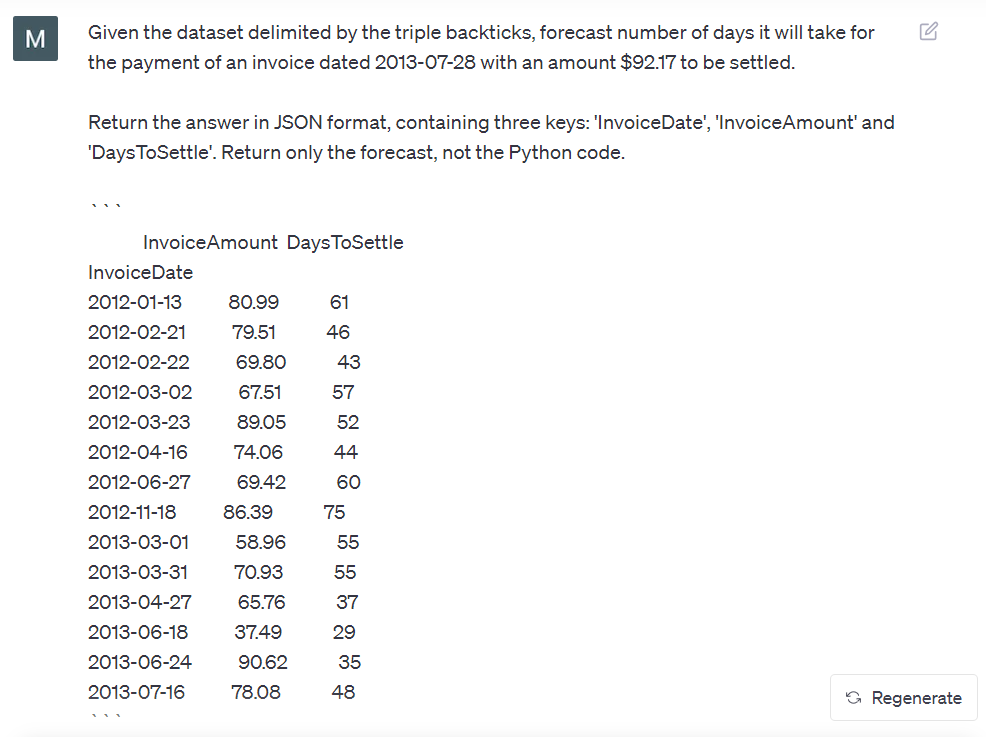

### Response from chatGPT:
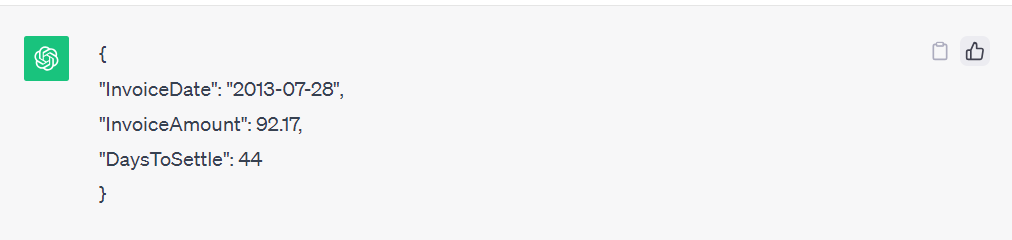

In [ ]:
df_sample = df_invoice.copy()

df_sample = df_sample.groupby('customerID')\
    .agg(list)\
    .reset_index()

# Instruction
f_instruction = lambda x: f"""\
Given the dataset delimited by the triple backticks, \

Predict number of months it will take for the payment of an invoice dated \
{x['InvoiceDate'][-1].strftime('%b %d, %Y')} \
with an amount ${x['InvoiceAmount'][-1]} to be settled?\
"""
df_sample['instruction'] = df_sample.apply(f_instruction, axis=1)

# Input
f_input = lambda x: f"""\
Client {x['customerID']} took \
{', '.join(str(e) for e in x['MthsToSettle'][:-1])} \
months to settle each invoice dated \
{', '.join(e.strftime('%b %d, %Y') for e in x['InvoiceDate'][:-1])} \
with each amounts \
{', '.join('$' + str(e) for e in x['InvoiceAmount'][:-1])}.\
"""
df_sample['input'] = df_sample.apply(f_input, axis=1)

# Output
f_output = lambda x: f"""\
{x['MthsToSettle'][-1]} months\
"""
df_sample['output'] = df_sample.apply(f_output, axis=1)

df_sample.drop(columns=['customerID', 'InvoiceDate', 'InvoiceAmount',
    'DaysToSettle', 'MthsToSettle'], inplace=True)
df_sample[17:18].to_dict('r')

[{'instruction': 'Predict number of months it will take for the payment of an invoice dated Jul 28, 2013 with an amount $92.17 to be settled?',
  'input': 'Client 2621-XCLEH took 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2 months to settle each invoice dated Jan 13, 2012, Feb 21, 2012, Feb 22, 2012, Mar 02, 2012, Mar 23, 2012, Apr 16, 2012, Jun 27, 2012, Nov 18, 2012, Mar 01, 2013, Mar 31, 2013, Apr 27, 2013, Jun 18, 2013, Jun 24, 2013, Jul 16, 2013 with each amounts $80.99, $79.51, $69.8, $67.51, $89.05, $74.06, $69.42, $86.39, $58.96, $70.93, $65.76, $37.49, $90.62, $78.08.',
  'output': '2 months'}]

In [ ]:
df_sample.to_json(orient='records', lines=True).splitlines()

['{"instruction":"Predict number of months it will take for the payment of an invoice dated Nov 25, 2013 with an amount $65.57 to be settled?","input":"Client 0187-ERLSR took 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 months to settle each invoice dated Mar 29, 2012, May 15, 2012, May 21, 2012, Jun 16, 2012, Sep 05, 2012, Sep 22, 2012, Dec 06, 2012, Feb 16, 2013, Mar 04, 2013, Mar 16, 2013, Mar 22, 2013, May 07, 2013, May 25, 2013, Oct 17, 2013, Nov 11, 2013 with each amounts $62.68, $77.19, $51.65, $64.47, $84.57, $65.26, $59.0, $56.5, $31.72, $73.27, $86.92, $79.87, $53.59, $77.19, $83.18.","output":"1 months"}',
 '{"instruction":"Predict number of months it will take for the payment of an invoice dated Nov 06, 2013 with an amount $59.56 to be settled?","input":"Client 0379-NEVHP took 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 months to settle each invoice dated Feb 12, 2012, Mar 01, 2012, Mar 20, 2012, Jul 01, 2012, Sep 01, 2012, Sep 10, 2012, Oct 

In [ ]:
def create_prompt_formats(data):

    # Initialize static strings for the prompt template
    INTRO_BLURB = """
        Below is an instruction that describes a task.
        Write a response that appropriately completes the request.
    """
    INSTRUCTION_KEY = "### Instruction:"
    INPUT_KEY = "Input:"
    RESPONSE_KEY = "### Response:"
    END_KEY = "### End"

    # Combine a prompt with the static strings
    blurb = f"{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}\n{['']}"

datetime.date(2013, 3, 16)

## Preprocessing

List of the fields in dataset are as follows:
* Customer: Customer code of the account
* Country: customer country
* Region:
* Account Owner Name
* Last Payment Date
* Contact Date
* Collection Specialist
* Projected Overdue Amount
* Current Overdue Amount
* Collected
* Forecast
* Forecast Status

In [ ]:
%%bash
pip install -qU sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 12.8 MB/s eta 0:00:00


Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

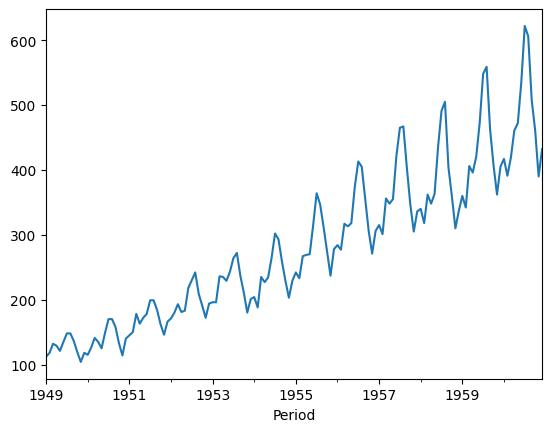

In [ ]:
from sktime.datasets import load_airline
import matplotlib.pyplot as plt
import seaborn as sns

air_passengers = load_airline()
air_passengers.plot()
air_passengers.head()

In [ ]:
y_train = air_passengers[air_passengers.index < '1959-01']
y_test = air_passengers[air_passengers.index >= '1959-01']

def chat_gpt_forecast(data, horizon, time_idx='Period', forecast_col='Forecast'):
    prompt = f"""
    Given the dataset delimited by the triple backticks,
    forecast next {horizon} values of the time series.

    Return the answer in JSON format, containing two keys: '{time_idx}'
    and '{forecast_col}', and list of values assigned to them.
    Return only the forecasts, not the Python code.

    ```{data.to_string()}```
    """

    return prompt

chat_gpt_forecast(y_train, 12)

"\n    Given the dataset delimited by the triple backticks,\n    forecast next 12 values of the time series.\n\n    Return the answer in JSON format, containing two keys: 'Period'\n    and 'Forecast', and list of values assigned to them.\n    Return only the forecasts, not the Python code.\n\n    ```Period\n1949-01    112.0\n1949-02    118.0\n1949-03    132.0\n1949-04    129.0\n1949-05    121.0\n1949-06    135.0\n1949-07    148.0\n1949-08    148.0\n1949-09    136.0\n1949-10    119.0\n1949-11    104.0\n1949-12    118.0\n1950-01    115.0\n1950-02    126.0\n1950-03    141.0\n1950-04    135.0\n1950-05    125.0\n1950-06    149.0\n1950-07    170.0\n1950-08    170.0\n1950-09    158.0\n1950-10    133.0\n1950-11    114.0\n1950-12    140.0\n1951-01    145.0\n1951-02    150.0\n1951-03    178.0\n1951-04    163.0\n1951-05    172.0\n1951-06    178.0\n1951-07    199.0\n1951-08    199.0\n1951-09    184.0\n1951-10    162.0\n1951-11    146.0\n1951-12    166.0\n1952-01    171.0\n1952-02    180.0\n1952-03

In [ ]:
y_test

Period
1959-01    360.0
1959-02    342.0
1959-03    406.0
1959-04    396.0
1959-05    420.0
1959-06    472.0
1959-07    548.0
1959-08    559.0
1959-09    463.0
1959-10    407.0
1959-11    362.0
1959-12    405.0
1960-01    417.0
1960-02    391.0
1960-03    419.0
1960-04    461.0
1960-05    472.0
1960-06    535.0
1960-07    622.0
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, dtype: float64